In [87]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
from classy import Class  
import math
from numpy.linalg import inv
from IPython.display import Image

In [200]:
#dm mass ranging between: 15 kev - 1 TeV
n_power = 2.0
dm_mass = 0.001 #GeV
step_size_cross_section = 2.5e-21 #* pow(dm_mass,0.15)

In [201]:
list_param = ['omega_b','omega_dmeff', 'h',  'A_s', 'n_s', 'tau_reio','sigma_dmeff']
list_fiducial = [0.02222, 0.1197,      0.69,  2.1955e-9, 0.9655, 0.06, 0]
list_step = [0.0001,     0.001,    0.01,   0.01e-9, 0.005, 0.02, step_size_cross_section]
list_param_step = list(zip(list_param, list_step))

Tcmb = 2.726

In [202]:
# Define the CLASS input dictionary, use defaults
params = {
    'output': 'tCl pCl',
    'l_max_scalars': 2500,
    'omega_b': list_fiducial[0],
    'omega_dmeff': list_fiducial[1],
    'h': list_fiducial[2],
    'A_s' : list_fiducial[3],
    'n_s' : list_fiducial[4], 
    'tau_reio' : list_fiducial[5],
    'sigma_dmeff': list_fiducial[6],
    'm_dmeff': dm_mass,
    'omega_cdm' : 1.0e-10,
    'npow_dmeff': n_power
}

# The usual CLASS code for computing C_l - fiducial only:
cosmo = Class()
cosmo.set(params)
cosmo.compute()
fiducial = cosmo.raw_cl(2500)
cosmo.struct_cleanup()
cosmo.empty()
ell = fiducial['ell']

In [203]:
#For right and left C_l's:
def utility_function_call_CLASS(input_dict, l_max=2500):
    """Compute Cl with this utility function, repeat less code."""
    cosmo = Class()
    cosmo.set(input_dict)
    cosmo.compute()
    temp_cl = cosmo.raw_cl(l_max)
    cosmo.struct_cleanup()
    cosmo.empty()
    return temp_cl

In [204]:
def compute_derivative(params, theta, XY, stepsize, fiduc):
    left_params = params.copy()
    if theta == 'sigma_dmeff':
        left_params[theta] = params[theta]
        right_params = params.copy()
        right_params[theta] = params[theta] + stepsize

        # get the C_l^XY and then compute the derivative!
        cl_XY_left = utility_function_call_CLASS(left_params)[XY]
        cl_XY_right = utility_function_call_CLASS(right_params)[XY]
        dClXY_dparam = (cl_XY_right - cl_XY_left) / (stepsize)
    else:
        left_params[theta] = params[theta] - stepsize
        right_params = params.copy()
        right_params[theta] = params[theta] + stepsize

        # get the C_l^XY and then compute the derivative!
        cl_XY_left = utility_function_call_CLASS(left_params)[XY]
        cl_XY_right = utility_function_call_CLASS(right_params)[XY]
        dClXY_dparam = (cl_XY_right - cl_XY_left) / (2 * stepsize)

    return dClXY_dparam / fiduc[XY], dClXY_dparam

def compute_d_cl(list_param_step, params, XY, fiducial):
    der_map = {}
    d_cl = {}
    for (par, stepsize) in list_param_step:
        norm_derivative, derivative = compute_derivative(params, par, XY, stepsize, fiducial)
        der_map[par] = norm_derivative
        d_cl[par] = derivative
    return d_cl

def compute_d_cl_der_map(list_param_step, params, XY, fiducial):
    der_map = {}
    d_cl = {}
    for (par, stepsize) in list_param_step:
        norm_derivative, derivative = compute_derivative(params, par, XY, stepsize, fiducial)
        der_map[par] = norm_derivative
        d_cl[par] = derivative
    return d_cl, der_map

#compute_d_cl(list_param_step, params, 'te', fiducial)""

In [205]:
dict_params, dict_norm_der = compute_d_cl_der_map(list_param_step, params, 'tt', fiducial)

<ipython-input-204-2287dab9b5cf>:22: RuntimeWarning: invalid value encountered in true_divide
  return dClXY_dparam / fiduc[XY], dClXY_dparam


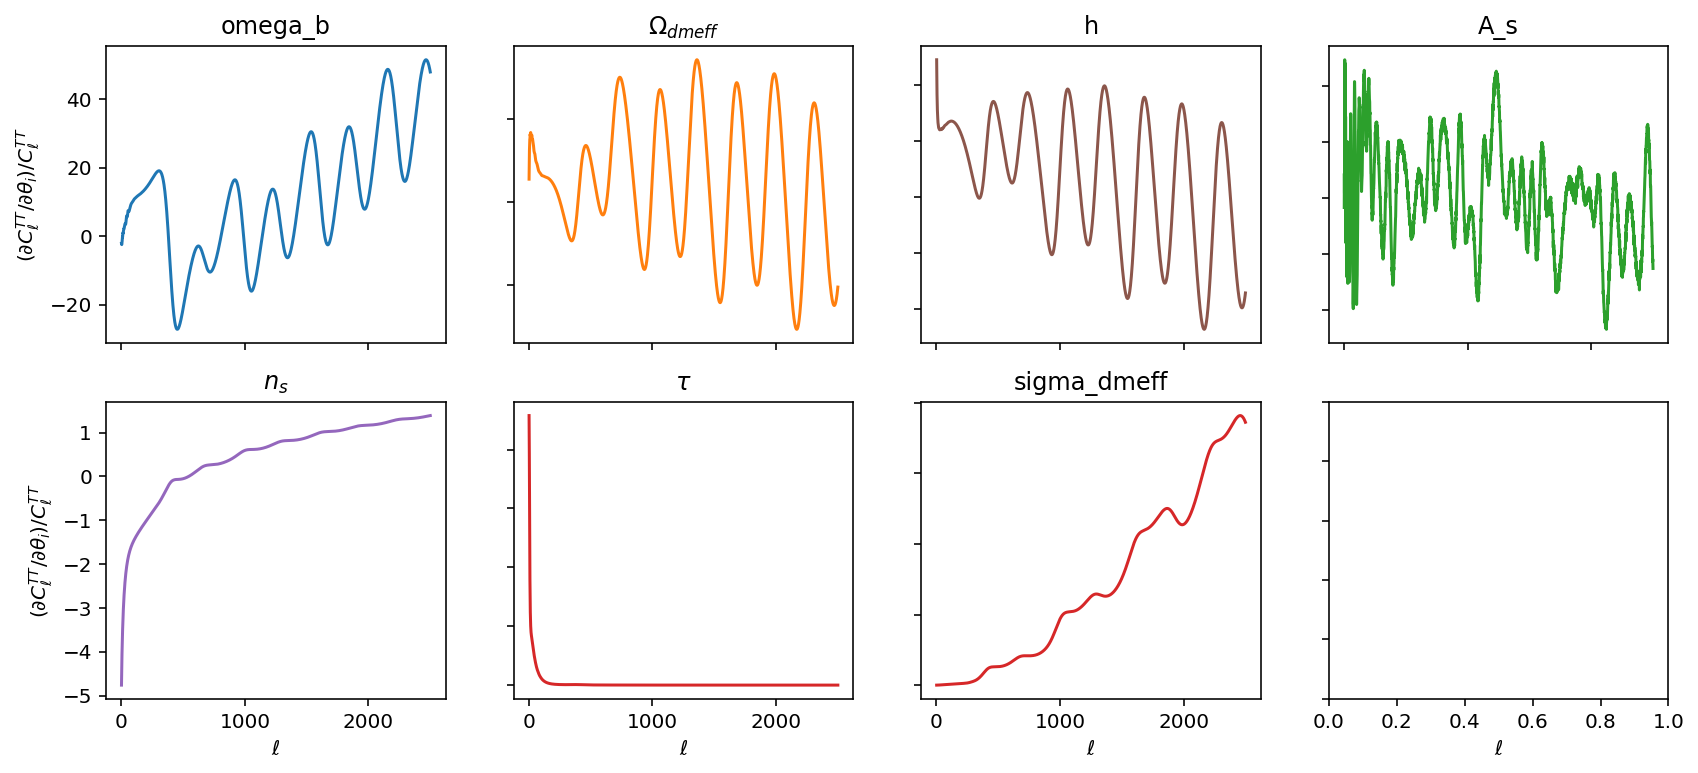

In [206]:
fig, axs = plt.subplots(2, 4, figsize=(14,6))

axs[0, 0].plot(dict_norm_der['omega_b'])
axs[0, 0].set_title('omega_b')

axs[0, 1].plot(dict_norm_der['omega_dmeff'], 'tab:orange')
axs[0, 1].set_title(r'$\Omega_{dmeff}$')

axs[0, 2].plot(dict_norm_der['h'], 'tab:brown')
axs[0, 2].set_title('h')

axs[0, 3].plot(dict_norm_der['A_s'], 'tab:green')
axs[0, 3].set_title('A_s')

axs[1, 0].plot(dict_norm_der['n_s'], 'tab:purple')
axs[1, 0].set_title(r'$n_s$')

axs[1, 1].plot(dict_norm_der['tau_reio'], 'tab:red')
axs[1, 1].set_title(r'$\tau$')

axs[1, 2].plot(dict_norm_der['sigma_dmeff'], 'tab:red')
axs[1, 2].set_title('sigma_dmeff')

for ax in axs.flat:
    ax.set(xlabel=r'$\ell$', ylabel=r'$(\partial C_{\ell}^{TT} / \partial \theta_i) / C_{\ell}^{TT}$')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
#fig.savefig("fisher_plots/derivative_C_l_TT_0.01GeV_n=2.png")


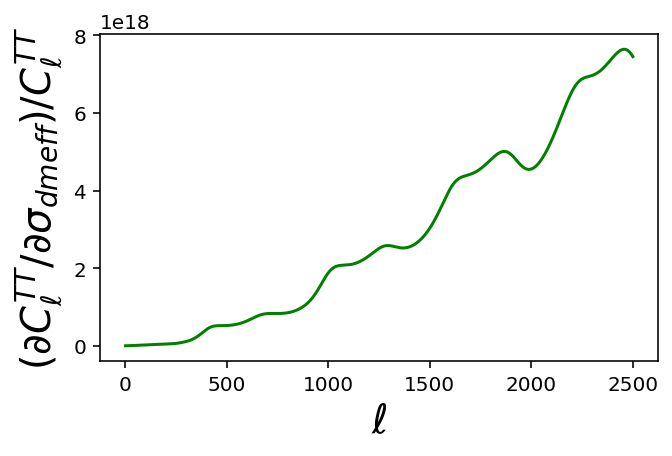

In [207]:
fig, ax = plt.subplots(figsize=(5, 3))
plt.plot(ell, dict_norm_der['sigma_dmeff'],'g-',label="hi")
plt.ylabel(r'$(\partial C_{\ell}^{TT} / \partial \sigma_{dmeff}) / C_{\ell}^{TT}$',size=20)
plt.xlabel(r'$\ell$',size=20)
plt.show()

In [208]:
sT = (33. * (np.pi/60./180. ))/(1.0e6*Tcmb)
sP = (56. * (np.pi/60./180. ))/(1.0e6*Tcmb)
f_sky = 0.65
theta_fwhm = 7. * (np.pi/60./180.)

l_min = 2
l_max = 2500

from scipy.special import expit

N_TT = np.zeros(l_max+1, 'float64')
N_EE = np.zeros(l_max+1, 'float64')

for l in range(l_min , l_max+1):
            N_TT[l] = 0
            N_TT[l] += sT**-2 *\
                    np.exp(
                        -l*(l+1)*theta_fwhm**2/8./np.log(2.))
            N_TT[l] = 1/N_TT[l]
            N_EE[l] = 0
            N_EE[l] += sP**-2 *\
                    np.exp(
                        -l*(l+1)*theta_fwhm**2/8./np.log(2.))
            N_EE[l] = 1/N_EE[l]
N_TT[ell < l_min] = 1e100
N_TT[ell > l_max] = 1e100
N_EE[ell < l_min] = 1e100
N_EE[ell > l_max] = 1e100

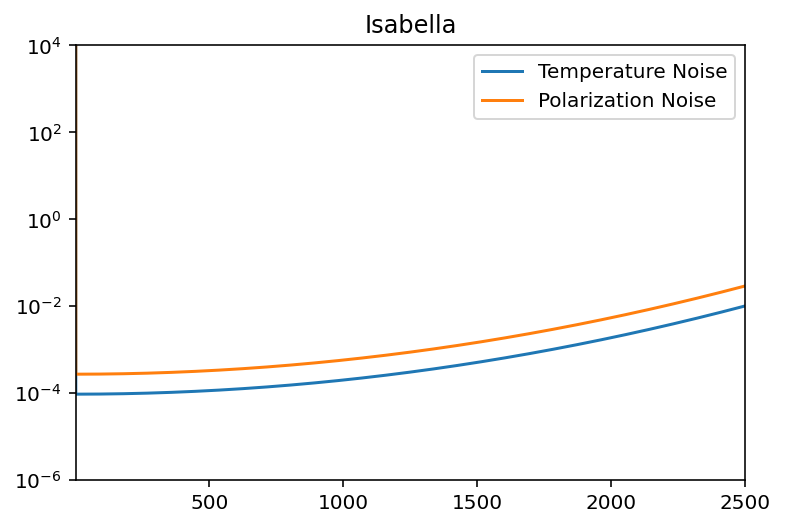

In [209]:
plt.plot(N_TT *(1.0e6*Tcmb)**2, '-',label="Temperature Noise")
plt.plot(N_EE *(1.0e6*Tcmb)**2, '-',label="Polarization Noise")
#plt.plot(fiducial['tt'] * (2.726*1e6)**2, '-',label="fiducial Cl_TT")
#plt.plot(fiducial['ee'] * (2.726*1e6)**2, '-',label="fiducial Cl_EE")
#plt.plot(fiducial['te'] * (2.726*1e6)**2, '-',label="fiducial Cl_TE")
plt.yscale('log')
plt.ylim(1e-6,1e4)
plt.xlim(2,2500)
plt.legend(loc="upper right")
plt.title('Isabella')
plt.show()


In [210]:
MAT_d_cl = [ [compute_d_cl(list_param_step, params, 'tt', fiducial), compute_d_cl(list_param_step, params, 'te', fiducial)]
            , [compute_d_cl(list_param_step, params, 'te', fiducial), compute_d_cl(list_param_step, params, 'ee', fiducial)] ]

<ipython-input-204-2287dab9b5cf>:22: RuntimeWarning: invalid value encountered in true_divide
  return dClXY_dparam / fiduc[XY], dClXY_dparam


In [211]:
MAT_cl = [
    [fiducial['tt'] + N_TT, fiducial['te']], 
    [fiducial['te'], fiducial['ee'] +N_EE]
        ]

In [212]:
#for i in list_param:
def compute_Q_i(i, l):
    d_Cl_i = [[MAT_d_cl[0][0][i][l], MAT_d_cl[0][1][i][l]], [MAT_d_cl[1][0][i][l], MAT_d_cl[1][1][i][l]]]
    cl = [[MAT_cl[0][0][l], MAT_cl[0][1][l]], [MAT_cl[1][0][l], MAT_cl[1][1][l]]]
    Q_i = np.matmul(inv(cl), d_Cl_i)
    return Q_i

def compute_F_ij(i, j):
    F_ij = 0
    for l in range(2, 2500):
        F_ij += 0.5*(2*l + 1) *f_sky * np.trace(np.matmul(compute_Q_i(i, l), compute_Q_i(j, l)))
    return F_ij

In [213]:
F =[]
for x in list_param:
    row = []
    for y in list_param:
        row.append(compute_F_ij(x, y))
    F.append(row)

In [214]:
covar = inv(F)
for n, i in enumerate(list_param):
    sigma_ii = np.sqrt(covar[n][n])
    print(i, sigma_ii)

omega_b 0.0001526944019423282
omega_dmeff 0.0013903497606717484
h 0.006376292849524197
A_s 1.7714363532786294e-11
n_s 0.005810163543380414
tau_reio 0.003817261762936629
sigma_dmeff 1.8509976255088786e-21


In [215]:
#file = open("sigma_dmeff.txt", "w")
#print("sigma_dmeff","dm_mass [GeV]", sigma_ii*2.48 ,file=file)
#print(sigma_ii, dm_mass,file=file)

In [216]:
#print(dm_mass, sigma_ii*2.48)

generating new axis
['omega_b', 'omega_dmeff', 'h', 'A_s', 'n_s', 'tau_reio', 'sigma_dmeff']


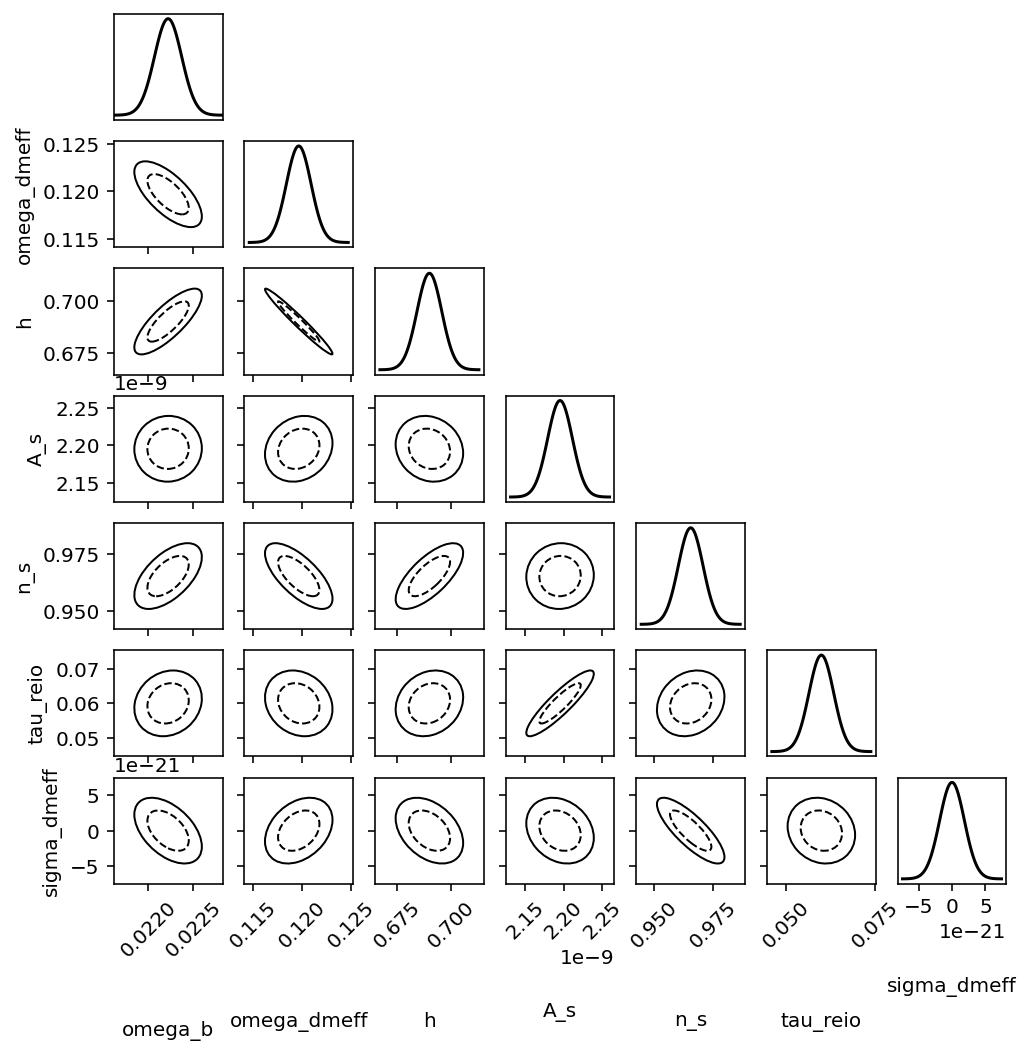

In [217]:
import fishchips.util

cov = np.linalg.inv(F)
fig, axes = fishchips.util.plot_triangle_base(list_param, list_fiducial, covar, labels=list_param);

#fig.savefig("fisher_plots/triagular_ellipses_0.001GeV_n=2.png")

In [218]:
dat = ('n-power=',n_power,'dm_mass=', dm_mass, 'stepsize =', step_size_cross_section,'fisher matrix =', F,i, "from cov matrix =",sigma_ii,"2-sigma =" ,sigma_ii*2.48)

In [219]:
print(dat)

('n-power=', 2.0, 'dm_mass=', 0.001, 'stepsize =', 2.5e-21, 'fisher matrix =', [[288513283.3155446, -62339813.45384248, -18880812.548323583, 738827545577765.5, 3111475.8544220594, -3305891.4002736025, 1.1054602498562885e+25], [-62339813.45384248, 34217853.671669096, 7591472.290584558, -1303275738007589.8, -1321451.14878883, 5727488.511691988, -5.629036489609597e+24], [-18880812.548323583, 7591472.290584558, 1928507.9520240969, -177048396680976.94, -308534.5714632121, 776791.6234320917, -1.0747428820094706e+24], [738827545577765.4, -1303275738007589.2, -177048396680976.94, 1.777531195945265e+23, 184105800417849.78, -779548320177615.1, 7.466633412821686e+32], [3111475.8544220594, -1321451.14878883, -308534.5714632121, 184105800417849.78, 407942.0728714201, -814909.0430604813, 1.245384629922751e+24], [-3305891.4002736015, 5727488.5116919875, 776791.6234320917, -779548320177615.1, -814909.0430604815, 3490380.073714657, -3.2788148687481244e+24], [1.1054602498562885e+25, -5.629036489609597e+

In [177]:
outF = open("fisher_data/planck_n=2/0.01GeV.txt", "w")
for i in dat:
  # write line to output file
  outF.write(str(i))
  outF.write("\n")
outF.close()